In [1]:
import sys
# path to local fv3net emulation directory
sys.path.append("/home/jmnugent/fv3net/workflows/emulation/")


In [2]:
import yaml
import tempfile
import pandas as pd
import matplotlib.pyplot as plt
# plotting functions
import utils as ut

In [3]:
# lots of functions for getting data , model, and training
import train_emulator as te

/home/jmnugent/miniconda3/envs/fv3net/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


## Load data and explore

### from original zarr (full dataset)

In [4]:
from loaders.mappers import open_phys_emu_training
from loaders.batches import batches_from_mapper

In [5]:
# data stored on gcs
data_url = "gs://vcm-ml-scratch/andrep/all-physics-emu/training-simple-phys-12day-w-micro"
# there are forecast data initialized for first of each month in 2016
init_times = [
    "20160801.000000"
]
dataset_names = [
    "state_after_dynamics.zarr",
    "physics_tendencies.zarr",
    "physics_component_tendencies.zarr"
]
vars_to_include = [
    "air_temperature",
    "specific_humidity",
    "tendency_of_specific_humidity_due_to_fv3_physics",
    "tendency_of_specific_humidity_due_to_microphysics",
]

In [6]:
mapper = open_phys_emu_training(data_url, init_times, consolidated=True, dataset_names=dataset_names)
# these batches are functionally the same as from the netcdf files
full_data_batches = batches_from_mapper(mapper, vars_to_include)

In [7]:
full_data_batches[0].time

<xarray.DataArray 'time' (sample: 13824)>
array([cftime.DatetimeJulian(2016, 8, 8, 12, 0, 0, 0),
       cftime.DatetimeJulian(2016, 8, 8, 12, 0, 0, 0),
       cftime.DatetimeJulian(2016, 8, 8, 12, 0, 0, 0), ...,
       cftime.DatetimeJulian(2016, 8, 8, 12, 0, 0, 0),
       cftime.DatetimeJulian(2016, 8, 8, 12, 0, 0, 0),
       cftime.DatetimeJulian(2016, 8, 8, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * sample   (sample) MultiIndex
  - tile     (sample) int64 3 2 0 0 4 1 0 4 2 1 4 2 ... 2 5 4 0 5 5 3 1 1 2 3 4
  - time     (sample) object 2016-08-08 12:00:00 ... 2016-08-08 12:00:00
  - x        (sample) float64 18.0 29.0 5.0 44.0 4.0 ... 27.0 28.0 30.0 7.0 20.0
  - y        (sample) float64 10.0 28.0 10.0 32.0 10.0 ... 23.0 22.0 22.0 21.0

In [8]:
#mapper act like a dict with timestep keys
list(mapper.keys())[:5]

['20160801.050000',
 '20160801.100000',
 '20160801.150000',
 '20160801.200000',
 '20160802.010000']

In [9]:
# batches are accessed as an item in a sequence
# mapper -> batch involves stacking everything but vertical dimension
example = full_data_batches[0]
example

<xarray.Dataset>
Dimensions:                                            (sample: 13824, z: 79)
Coordinates:
  * sample                                             (sample) MultiIndex
  - tile                                               (sample) int64 5 2 ... 2
  - time                                               (sample) object 2016-0...
  - x                                                  (sample) float64 14.0 ...
  - y                                                  (sample) float64 13.0 ...
Dimensions without coordinates: z
Data variables:
    air_temperature                                    (sample, z) float64 23...
    specific_humidity                                  (sample, z) float64 4....
    tendency_of_specific_humidity_due_to_fv3_physics   (sample, z) float64 1....
    tendency_of_specific_humidity_due_to_microphysics  (sample, z) float64 0....

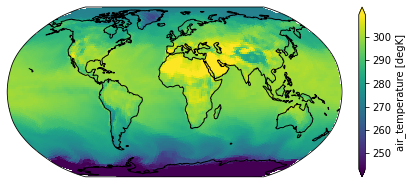

In [10]:
# example plotting a spatial map
# must be [tile, x, y] dimensions
ut.plot_var(example.unstack("sample"), "air_temperature", isel_kwargs=dict(time=0, z=75))

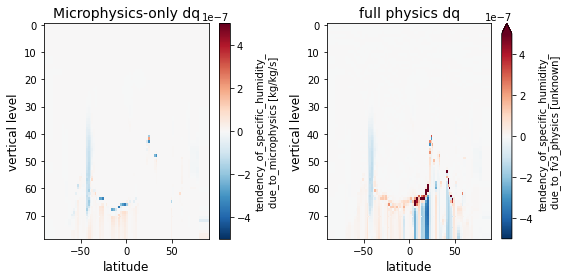

In [11]:
## example plotting vertical transect comparison
micro_dq = "tendency_of_specific_humidity_due_to_microphysics"
allphys_dq = "tendency_of_specific_humidity_due_to_fv3_physics"

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,4)
vmin, vmax = -5e-7, 5e-7 
ut.plot_meridional(
    example.unstack("sample").isel(time=0)[micro_dq],
    micro_dq,
    ax=ax[0],
    title="Microphysics-only dq",
    vmin=vmin,
    vmax=vmax
)
ut.plot_meridional(
    example.unstack("sample").isel(time=0)[allphys_dq],
    allphys_dq,
    ax=ax[1],
    title="full physics dq",
    vmin=vmin,
    vmax=vmax
)
plt.tight_layout()

### from subset netcdf files 

In [12]:
data_path = "/mnt/disks/scratch/training/training-subsets/simple-phys-hybridedmf-w-microphysics-12day/"
batches = te.get_subsampled_batches(data_path)

In [13]:
air_temperature = batches[0]["air_temperature"]

In [14]:
# multi index is dropped before netcdf save, so we have to add back in
# to get full spatial field
def _get_multi_idx(ds):
    coords_to_unstack = ["tile", "x", "y"]
    coords = [ds.coords[key].values for key in coords_to_unstack]
    multi_idx = pd.MultiIndex.from_tuples(zip(*coords), names=coords_to_unstack)
    
    ds = ds.reset_coords(coords_to_unstack, drop=True)
    return ds.assign_coords({"sample": multi_idx})
    


In [15]:
example =_get_multi_idx(batches[0])
unstacked = example.unstack("sample")

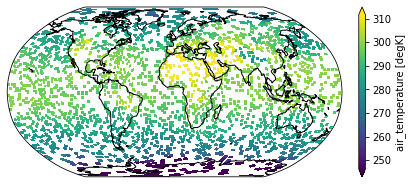

In [16]:
ut.plot_var(
    unstacked,
    "air_temperature",
    isel_kwargs=dict(z=75)
)

## NN Example

Many different ways to generate models in tensorflow.

This example shows the "Keras"-style usage

In [17]:
import tensorflow as tf

In [18]:
def get_emu_model(input_shape, output_shape):

    inputs = tf.keras.layers.Input(input_shape)
    hidden_layer = tf.keras.layers.Dense(
        250, activation=tf.keras.activations.tanh
    )(inputs)
    outputs = tf.keras.layers.Dense(output_shape)(hidden_layer)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.optimizers.Adam(learning_rate=1e-3)

    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    return model


In [19]:
model = get_emu_model(10, 20)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 250)               2750      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                5020      
Total params: 7,770
Trainable params: 7,770
Non-trainable params: 0
_________________________________________________________________


Models can be composed within other models.  You can control whether they should be trained together or not by freezing internal parameters!

In [21]:
model2 = get_emu_model(10, 20)

In [22]:
ensemble_inputs = tf.keras.layers.Input(10)
member1 = model(ensemble_inputs)
member2 = model2(ensemble_inputs)
avg = tf.keras.layers.Average()([member1, member2])
ensemble = tf.keras.Model(inputs=ensemble_inputs, outputs=avg)

In [23]:
ensemble.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 20)           7770        input_3[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 20)           7770        input_3[0][0]                    
__________________________________________________________________________________________________
average (Average)               (None, 20)           0           model[0][0]                      
                                                                 model_1[0][0]              

##  Training a model

This will change as we get some of the shared tooling into fv3fit

### Load configuration

In [24]:
# example of a yaml config
config_yaml = """
train_data_path: "/mnt/disks/scratch/training/training-subsets/simple-phys-hybridedmf-w-microphysics-12day/"
test_data_path: "/mnt/disks/scratch/testing/validation-subsets/simple-phys-hybridedmf-w-microphysics-12day/"
input_variables:
  - "air_temperature"
  - "specific_humidity"
output_variables:
  - "tendency_of_specific_humidity_due_to_fv3_physics"
vertical_subselections:
    specific_humidity: [15, null]
    tendency_of_specific_humidity_due_to_fv3_physics: [15, null]
save_path: gs://vcm-ml-scratch/andrep/test-emu-model-delete
antarctic_only: False
fit_kwargs:
  epochs: 1
  validation_freq: 5
  batch_size: 64
  verbose: 2
"""

In [25]:
# just a simple way to go from the string in the notebook into
# what I usually use for loading from (a yaml file)
with tempfile.NamedTemporaryFile(mode="w") as f:
    f.write(config_yaml)
    f.flush()
    config = te.load_config(f.name)

In [26]:
config

TrainingConfig(train_data_path='/mnt/disks/scratch/training/training-subsets/simple-phys-hybridedmf-w-microphysics-12day/', test_data_path='/mnt/disks/scratch/testing/validation-subsets/simple-phys-hybridedmf-w-microphysics-12day/', input_variables=['air_temperature', 'specific_humidity'], output_variables=['tendency_of_specific_humidity_due_to_fv3_physics'], save_path='gs://vcm-ml-scratch/andrep/test-emu-model-delete', vertical_subselections={'specific_humidity': slice(15, None, None), 'tendency_of_specific_humidity_due_to_fv3_physics': slice(15, None, None)}, antarctic_only=False, fit_kwargs={'epochs': 1, 'validation_freq': 5, 'batch_size': 64, 'verbose': 2})

### Get train/test data pipeline

In [27]:
train_batches = te.get_subsampled_batches(config.train_data_path)
test_batches = te.get_subsampled_batches(config.test_data_path)

In [28]:
# input preprocessing normalizes, stacks and groups into X, y
preproc, save_info, y_features = te.load_batch_preprocessing_chain(config, train_batches, num_std_batches=96)


In [29]:
preproc

Compose(<function stack_io at 0x7fcc41c54ef0>, <function standardize at 0x7fcc41c54950>, <function extract_ds_arrays at 0x7fcc41c4bb00>)

In [30]:
X, y = preproc(train_batches[0])

/home/jmnugent/fv3net/external/fv3fit/fv3fit/_shared/_transforms/emu_transforms.py:50: RuntimeWarning: invalid value encountered in true_divide
  standardized[varname] = (dataset[varname] - mean) / std


In [31]:
# warning right now is being thrown because the ozone mixing ratios tendencies, it seems

In [32]:
X.shape

(2560, 143)

In [33]:
y.shape

(2560, 64)

In [34]:
train_ds = te.batches_to_tf_dataset(preproc, train_batches[:12])
valid_ds = te.batches_to_tf_dataset(preproc, test_batches[:12])

### Train model

In [35]:
model = get_emu_model(X.shape[-1], y.shape[-1])

In [36]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 143)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               36000     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16064     
Total params: 52,064
Trainable params: 52,064
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.fit(
    train_ds.batch(64),
    epochs=10,
    validation_data=valid_ds.batch(64),
    validation_freq=2
)

Epoch 1/10
480/480 [==============================] - 12s 7ms/step - loss: 0.2756 - mae: 0.2039
Epoch 2/10
480/480 [==============================] - 14s 27ms/step - loss: 0.2545 - mae: 0.1747 - val_loss: 0.2842 - val_mae: 0.1916
Epoch 3/10
480/480 [==============================] - 1s 2ms/step - loss: 0.2513 - mae: 0.1722
Epoch 4/10
480/480 [==============================] - 2s 4ms/step - loss: 0.2491 - mae: 0.1704 - val_loss: 0.2791 - val_mae: 0.1834
Epoch 5/10
480/480 [==============================] - 1s 2ms/step - loss: 0.2475 - mae: 0.1685
Epoch 6/10
480/480 [==============================] - 2s 4ms/step - loss: 0.2461 - mae: 0.1668 - val_loss: 0.2762 - val_mae: 0.1791
Epoch 7/10
480/480 [==============================] - 1s 2ms/step - loss: 0.2449 - mae: 0.1652
Epoch 8/10
480/480 [==============================] - 2s 4ms/step - loss: 0.2439 - mae: 0.1638 - val_loss: 0.2738 - val_mae: 0.1756
Epoch 9/10
480/480 [==============================] - 1s 2ms/step - loss: 0.2430 - mae: 0

In [38]:
out = model.predict(X)

In [39]:
out.shape

(2560, 64)

##### My additions

In [39]:
out

array([[ 1.2636317e-02,  3.4323040e-02,  4.0472440e-02, ...,
         2.4543709e-01,  2.3803475e-01,  1.3328189e-01],
       [-2.3408815e-02, -1.3203620e-02,  7.0654601e-02, ...,
        -1.7365900e-01, -1.7372502e-01, -1.1385121e-01],
       [-1.1511752e-02, -2.9244000e-02,  1.5428551e-03, ...,
        -5.0271843e-03,  4.8653096e-02,  5.0514005e-02],
       ...,
       [ 3.1957203e-03,  1.6376261e-02, -2.8220452e-02, ...,
         9.6999012e-02,  1.2579155e-01,  1.3262703e-01],
       [ 2.6352471e-04, -7.3603585e-02, -2.2786595e-03, ...,
        -1.1434033e-01, -2.7901262e-02,  1.3342813e-02],
       [-2.0008767e-02,  7.1837872e-02, -5.6429096e-03, ...,
        -4.1933519e-01, -4.3478844e-01, -3.9194933e-01]], dtype=float32)

In [41]:
y.shape

(2560, 64)

In [43]:
import numpy as np

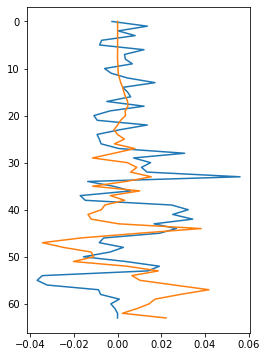

In [48]:
fig, ax = plt.subplots(figsize=(4, 6))
ax.plot(np.mean(out, axis=0), np.arange(0, 64), label='predicted')
ax.plot(np.mean(y, axis=0), np.arange(0, 64), label='true')
plt.gca().invert_yaxis()
plt.show()
